<a href="https://colab.research.google.com/github/Blueprint-GitHub/Study_Note/blob/main/Hands_on_ML_chapter_11_How_to_DL_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**딥러닝 모델의 훈련속도와 성능을 높이는 전략**
1. 적절한 초기화 방법 사용하기
2. 좋은 활성화 함수 사용하기
3. 배치 정규화 사용하기
4. 사전 훈련된 네트워크의 일부를 재사용하기\
   (전이 학습, 비지도 사전 훈련, 보조 작업 사전 훈련)
5. sgd 외의 고급 옵티마이저 사용하기
6. 학습률 스케줄링
7. 규제

**저자가 추천하는 실용적인 가이드 라인**    
**기본 DNN 설정**
- 커널 초기화 : he_normal
- 활성화 함수 : 얕은 신경망 : ELU, 깊은 신경망 : Swish
- 정규화 : 얕은 신경망일 경우 없음, 깊은 신경망은 배치 정규화
- 규제 : 조기 종료, 필요하면 가중치 감쇠
- 옵티마이저 : 네스테로프 가속 경사 또는 AdamW
- 학습률 스케줄 : 성능 기반 스케줄링 또는 1사이클 스케줄링

\
**자기 정규화를 위한 DNN 설정** (네트워크가 완전 연결 층을 쌓은 단순한 모델일때)
- 커널 초기화 : 르쿤 초기화
- 활성화 함수 : SELU
- 정규화 : 없음(자기 정규화)
- 규제 : 필요하다면 𝛂 드롭 아웃
- 옵티마이저 : 네스테로프 가속 경사
- 학습률 스케줄 : 성능 기반 스케줄링 또는 1사이클 스케줄링


# **1. 적절한 초기화 방법**



In [ ]:
#그레이디언트 소실 / 발산을 방지하기 위한 활성화 함수 별 가중치 초기화 전략

**사용 예시**

keras.layers.Dense(50, activation = 'relu',
                   kernel_initializer = 'he_normal')

글로럿 초기화(Xavier) : 케라스 기본값, tanh, logi, softmax
he 초기화 : Relu, ELU, GELU 등에 사용
르쿤 초기화 : SELU


# **2. 여러가지 고급 활성화 함수**

1. 언제나 Relu를 먼저 시도해본다
2. 더 복잡한 작업에는 swish를 시도해본다 (activaiton = 'swish')
3. 실행속도가 중요한 경우 LeakyRelu를 사용해볼 수 있다. (He 초기화 사용)


In [ ]:
LeakyRelu
그레이디언트 소실을 방지한다, 1505.00853논문에 따르면 Relu보다
대부분의 상황에서 좋은 결과를 얻는다고 한다. 작은 기울기 알파 = default 0.3
activation에서 바로 못쓰고 아래와 같이 사용해야 한다.

keras.layers.LeakyReLU(alpha=0.3)
activation = leaky_relu, kernel_initializer = 'he_normal'


ELU(exponential linear unit)
Relu와 그 변형들이 매끄러운 함수가 아니라는 단점을 보완하기 위해 양수 구간에서는 Relu처럼 동작하지만 음수 구간에서는 부드럽게 하강하는 함수를 구현하였다.
Relu나 그 변형들보다 계산이 느리다.

activation = 'elu' kernel_lnitializer = 'he_normal'


SELU
완전 연결층만 쌓아서 신경망(MLP)를 만들고, 모든 활성화 함수를 SELU로 하면
네트워크가 자기 정규화 된다. 이는 그레이디언트 소실과 폭주 문제를 막아주며
아주 깊은 MLP에서 다른 활성화 함수보다 높은 성능을 보여준다.
조건

입력 특성이 표준화되어야 한다(평균0, 표준 편차1)
모든 은닉층의 kernel_initializer = 'lecun_normal'
l1,l2,배치 정규화,드롭 아웃,맥스-노름 같은 정규화를 사용할 수 없다.


GELU
Relu와 거의 유사한데 음수 구간에 작은 웅덩이 하나가 있다. 다른 모든 활성화 함수보다
성능이 높을 확률이 많지만,그 성능 향상 폭에 비해 계산을 위해 필요한 추가 비용이 정당화되지
않는 경우도 많이 있다. 𝛽 = 1.702를 사용하는 일반화된 Swish함수와 같다.
가중치 초기화는 기본 or He 초기화



Swish
GELU보다 더 큰 웅덩이가 있음. 복잡한 작업에 사용 가능 가중치 초기화는 기본 or He 초기화

# **3. 배치 정규화 (BN ; batch Normalization)**

Relu 및 그 변형과 He초기화 방법을 사용하면 그레이디언트 소실/발산 문제를
줄일 수 있지만\
완전히 제거할수는 없으므로 이를 해결하기 위해 배치 정규화를 사용한다.\
특히 깊은 CNN 등에서 효과적이다. (사실상 모든 CNN에 배치 정규화를 사용한다고
가정한다.)

1. **정규화 효과**\
    신경망의 첫 번째 층에 배치 정규화 층 BatchNormalization을 두면\
    StandardScaler나 Normalizaion 클래스가 필요가 없어짐.

2. **학습 속도 향상**\
   각 에포크 마다의 시간은 오래걸리지만 빠른 수렴으로 그것이 상쇄되어\
   더 빠르고 좋은 성능을 내는 모델을 만들어준다.

3. **규제**\
   또한 미니 배치마다 평균과 표준 편차를 계산하는 과정에서 훈련 데이터에 일종에
   잡음을 넣는 역할을 해서 규제 역할을 수행하기도 한다. 이는 미니배치의 크기가
   클수록 효과는 줄어들고, 규제 역할을 하긴 하지만 Dropout도 같이 써야한다.

4. **그레이디언트 소실/폭발 문제 완화**

In [ ]:
사용 예시

model = keras.Sequential([
    layers.Flatten(input_shape=[28, 28]),
    layers.Dense(300, activation = 'relu',
                 kernel_initializer="he_normal", use_bias=False),
    layers.BatchNormalization(),
    layers.Dense(100, activation = 'relu',
                 kernel_initializer="he_normal", use_bias=False),
    layers.BatchNormalization(),
    layers.Dense(10, activation="softmax")
])
"""
배치 정규화 앞 층에는 bias가 필요 없으므로 use_bias = False 설정

첫 번째 층에서 사용하려면 adapt() 메서드를 호출하면 됨. (성능은 비슷)

relu를 사용했으므로 he_normal로 가중치 초기화

파라미터 개수는 입력 * 4

출력 층 위에있는 마지막 배치정규화는 역전파로 업데이트되지 않는다.

배치 정규화를 활성화 전 후로 할거냐에 따라 논란이 있는데, 활성화 함수를 뒤로 미룰거면 아래와 같이 하면 된다
"""
    layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    layers.BatchNormalization(),
    layers.Activation("relu")
"""
하이퍼파라미터는 모멘텀과 axis가 있는데, 모멘텀은 일반적으로 0.9 0.99와 같은 값을 사용하며
데이터셋이 크고 미니배치가 작을수록 0.9999..처럼 1에 가깝게 한다.
axis는 기본 -1로 그 전에 들어오는 샘플의 개수이고
독립적으로 다루고 싶다면 axis = [1,2] 처럼 설정해야 한다.
"""


# **4. 전이학습(transfer learning)**
미리 훈련된 모델을 가져와, 마지막 층의 일부만 수정하여 사용하는 학습 방법.\
훈련 데이터가 많을수록 더 많은 층의 동결을 해제할 수 있으며,\
재사용 층의 동결을 해제할때는 학습률을 줄이는 것이 좋다.

but 작은 완전 연결 네트워크에서는 잘 작동하지 않고, CNN등에서 효과적이다.


In [ ]:
#사용 예시
 model_A = tf.keras.models.load_model("my_model_A")

 #clone을 만들지 않으면 모델B_A를 훈련할때 모델 A도 변경된다.
 #set_weights를 가져오지 않으면 구조만 가져온다.
 model_A_clone = tf.keras.models.clone_model(model_A)
 model_A_clone.set_weights(model_A.get_weights())

 model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
 model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))
 """
하지만 이렇게 바로 사용하면 출력층이 랜덤하게 초기화 되어 있어서
출력층의 역전파가 불러온 모델A의 가중치를 망칠 수 있다.
따라서 아래와 같이 가중치를 동결해서 몇 번 훈련한 뒤, 다시 동결을 풀 수도 있다.
"""


#중요 : 층을 동결하거나 동결을 해제할때는 반드시 모델을 새로 컴파일 해야한다.

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

# **5. 고속 옵티마이저**

아주 큰 DNN에서는 훈련 속도가 크게 느려질 수 있는데, 고속 옵티마이저\
기술을 적절하게 활용하면 훈련 속도를 크게 향상시킬 수 있다.

In [ ]:
1. 모멘텀 최적화
보통의 경사하강법은 경사가 가파르면 큰 스텝으로 이동하고 작으면 작은 스텝으로 움직이지만
속도가 더 빨라지진 않는다. 따라서 지역 최저점을 만나면 그곳을 벗어나는데 오랜 시간이 걸린다. 이때 모멘텀 최적화를 사용하면 그레이디언트를 가속도처럼 사용하여 지역 최저점을 빠르게 탈출하도록 돕고, 결과적으로 더 빠른 시간에 수렴되도록 한다.

 일반적으로 모멘텀 0.9에서 잘 작동한다.
optimizer = tf.keras.optimizer.SGD(learning_rate = 0.001, momentum = 0.9)
1-1. 네스테로프 모멘텀 최적화
기존 모멘텀을 두 번 중복 적용한 것으로 표현되는 최적화 방법으로
다음 step의 그레이디언트를 미리 계산해서 그 방향으로 나아가는 방법이다.\

optimizer = tf.keras.optimizer.SGD(learning_rate = 0.001,
momentum = 0.9, use_nesterov = True)
2. AdaGrad
적응적 학습률(Adaptive learning rate)를 사용하는 옵티마이저로
학습률이 감소되지만 경사가 가파른 차원에서 더 빠르게 감소되어 전역 최적점 방향으로
손실이 곧장 향하도록 유도한다. 그러나 이 학습률 감소 문제때문에 전역최적점에 도착하기 전에
학습률이 0이 되어버릴 수 있기 때문에 DNN에서는 사용하기 어렵다.
(선형 회귀 같은 문제에서는 가능)

3. RMSProp
keras의 기본 옵티마이저로 AdaGrad의 알고리즘을 조금 수정해
최근의 그레이디언트만 사용해 알고리즘이 멈추는 것을 방지한다.

4. Adam(적응적 모멘트 추정 :adaptive moment estimation)
모멘텀 최적화 + RMSProp으로 적응적 학습률 알고리즘이며
Beta1(모멘텀) Beta2(RMSProp 감쇠율) 하이퍼 파라미터가 있다.

4-1 Adam 변형 모델
AdaMax(이론적으로 안정적이지만 일반적으로 Adam의 결과가 더 나음),
Nadam(Adam + 네스테로프, 일반적으로 Adam보다 나음)
AdamW(Adam + 가중치 감쇠(l2 정규화 효과))

# **6. 학습률 스케줄링**

적절한 학습률을 찾기 위해서 큰 학습률에서 시작해서 학습 속도가 느려지면\
작은 학습률로 낮춰 더 좋은 솔루션을 더 빨리 발견하게 하는 방법




In [ ]:
#1. 거듭제곱 기반 스케줄링 (일정 step마다 학습률을 1/n로 줄임)

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, weight_dacay = 1e-4)

#2. 지수 기반 스케줄링 (일정 step마다 학습률을 1/10으로 줄임)
def exponetial_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return 0.01 * 0.1 ** (epoch / 20)
    return exponetial_decay_fn

exponential_decay_fn = exponential_decay(lr0 = 0.01, s = 20)

(LearningRateScheduler는 에포크마다 학습률을 업데이트 한다.)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponetial_decay)
history = model.fit(X_train, y_train, [...], callbacks = [lr_scheduler])
(함수를 쓰지 않고 keras API에서도 사용 가능하다)
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizer.schedules.ExponetialDecay(
    initial_learning_rate = 0.01, decay_steps = n_steps, decay_rate = 0.1)
optimizer = tf.keras.optimizer.SGD(learning_rate = scheduled_learning_rate)


#3. 구간별 고정 스케줄링 (일정 epoch마다 다른 학습률을 사용해 훈련)
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn
piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

n_epochs = 25
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

케라스 API에서 구간별 고정 스케줄링을 지원한다.
아래 코드의 의미는 다음과 같다.

첫 5 * n_steps_per_epoch 스텝만큼 0.01로 학습하고
그 다음 15 * n_steps_per_epoch 스텝만큼 0.005로 학습한다.
그 후로는 0.001로 학습한다.

scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

#4. 성능 기반 스케줄링 (일정 step마다 검증 오차를 측정하고 오차가 줄지않을때 학습률을 줄임)

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
#patience만큼 검증 손실이 향상되지 않으면 학습률에 factor를 곱한다.
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])
#5. 1사이클 스케줄링 (학습률이나 모멘텀의 구간을 정하고 그 구간에서 왔다갔다 하면서 조정됨, 절반은 내려가다가 절반은 올라감)

#먼저 아래 코드로 1사이클의 최적의 최대학습률 max_lr을 찾는다.
import math
from copy import deepcopy

K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # 지금까지의 평균 손실
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = deepcopy(model.get_weights())
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xscale('log')
    plt.xlabel("learning_rate")
    plt.ylabel("loss")
    plt.title("Learning rate vs Loss")
    plt.grid()

model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

#그 다음 원사이클 스케줄러를 구현해 콜백에 넣고 모델을 훈련한다.
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0
`
    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1
`
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, lr)

model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])
#6. 코사인 스케줄링

#위 아래로 왔다갔다하면서 스케줄링 조정, 과적합 위험이 높은 모델에서 효과적.
import tensorflow as tf

# Cosine Decay Restarts 스케줄러 설정
initial_learning_rate = 0.1
first_decay_steps = 1000
t_mul = 2.0
m_mul = 0.9
alpha = 0.1

lr_schedule = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps,
    t_mul=t_mul,
    m_mul=m_mul,
    alpha=alpha
)

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

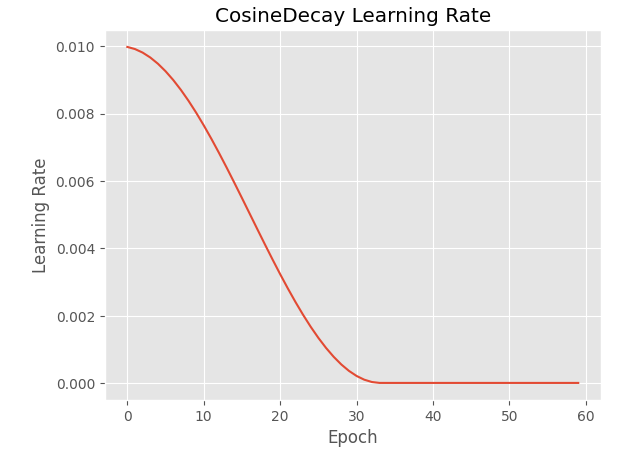

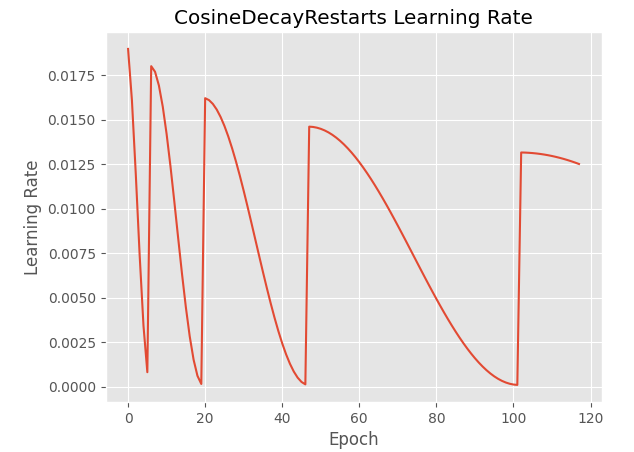

# **7. 규제**



In [ ]:
# l1규제와 l2규제
""""
신경망의 연결 가중치를 제한하기 위해 l2 규제를 사용하거나
많은 가중치가 0인 희소 모델(특성 선택)을 만들기 위해 l1 규제 등을 사용할 수 있다.
Note : L2규제는 SGD,모멘텀 최적화와 사용하는건 괜찮지만 Adam을 쓰고 싶다면

AdamW를 사용해야 한다.
"""
#케라스 연결 층에 l2 규제 적용
layer = layers.Dense(100, activation = 'relu',
                     kernel_intializer = 'he_normal',
                     kernel_regularizer = keras.regularizer.l2(0.01))

#일반적으로 네트워크의 모든 은닉층에 동일한 활성화 함수, 초기화, 규제를 적용하기 때문에
#partial 함수를 사용한 반복문을 사용해 코드의 가독성을 늘릴 수 있다.
from function import partial

RegularziedDense = partial(layers.Dense,
                           activation = 'relu',
                           kernel_initializer = 'he_normal',
                           kernel_regularizer = keras.regularizer.l2(0.01))

model = keras.Sequential([
    layers.Flatten(input_shape = [28, 28]),
    RegularziedDense(100),
    RegularziedDense(100),
    RegularziedDense(10, activation = 'softmax')
])

# Dropout
"""
RNN에서는 20에서 30% CNN에서는 40~50%를 적용한다.
일반적으로 맨 위층에서 세 번째 층까지만 드롭아웃을 적용하거나.
마지막 층에만 적용한다.
무작위로 뉴런들이 제외되기 때문에, 각각의 뉴런은 스스로가 최대한 유용해지고
모든 입력 뉴런에 주의를 기울이게 하는 효과를 얻게 된다.
또한 각각의 step마다 제외되는 뉴런이 바뀌기 때문에 10,000번의 훈련 스텝에서
10,000개의 다른 신경망을 앙상블 하는 듯한 효과를 얻을 수 있다.
몬테카를로 드롭아웃(MC Dropout)
여기서 range를 늘릴 수록 예측과 불확실성 추정이 더 정확해지지만,
예측 시간도 늘어나고 일정 샘플 이상에서는 정확도가 향상되지 않는다.
"""
import numpy as np
y_probas = np.stack([model(X_test), training = True)
                 for sample in range(100)])
y_proba = y_probas.mean(axis = 0)

#시퀀셜 모델은 아래와 같이 구현할 수 있다.
import tensorflow as tf
from tensorflow.keras.layers import Dropout

class MCDropout(Dropout):
 def call(self, inputs, training=None):
     return super().call(inputs, training=True)

model = tf.keras.Sequential([
 tf.keras.layers.Dense(64, activation='relu'),
 MCDropout(0.5),
 tf.keras.layers.Dense(1, activation='sigmoid')
])
y_probas = np.stack([model(X_test), training = True)
                 for sample in range(100)])
y_proba = y_probas.mean(axis = 0)


#함수형API에서는 아래와 같이 구현하면 된다.
inputs = Input(shape=(input_shape,))
x = Dense(64, activation = 'relu')(inputs)
x = Dropout(0.5)(x, training = True)  # training = True
outputs = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs, outputs)
y_probas = np.stack([model(X_test, training = True)
                 for sample in range(100)])
y_proba = y_probas.mean(axis = 0)
"""
맥스-노름 규제
각각의 뉴런의 연결 가중치를 제한 하는 방법으로, 배치 정규화 등을 사용하지
않았을때, 과대적합을 감소시키는데 도움을 준다.
노름(Norm) 이란?
노름은 벡터의 '크기' 또는 '길이'를 측정하는 방법.

L1 노름: 벡터의 요소 절대값들의 합.
L2 노름: 벡터 요소들의 제곱합의 제곱근으로, 유클리디언 거리를 나타낸다..
무한대 노름: 벡터 요소들 중 절대값이 가장 큰 것.
"""
dense = layers.Dense(100, activation = 'relu',
                   kernel_initializer = 'he_normal',
                   kernel_constraint = keras.constraints.max_norm(1.))
#모든 층에 최대노름을 지정하는 방법.
MaxNormDense = partial(tf.keras.layers.Dense,
                     activation="relu", kernel_initializer="he_normal",
                     kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=[28, 28]),
  MaxNormDense(100),
  MaxNormDense(100),
  tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
            metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                  validation_data=(X_valid, y_valid))

# **Hyperopt (ML모델 튜닝)**



In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# 하이퍼파라미터 공간 정의
space = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'n_estimators': hp.choice('n_estimators', range(10, 100)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

# 목적 함수 정의
def objective(params):
    clf = RandomForestClassifier(**params)
    acc = cross_val_score(clf, X_train, y_train, cv=5).mean()
    return -acc  # 최대화 대신 최소화

# 최적화 실행
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100)
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
import numpy as np

# 하이퍼파라미터 공간 정의
space = {
    'n_estimators': hp.choice('n_estimators', range(100, 1000)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth' : hp.choice('max_depth', range(5, 15)),
    'min_child_weight': hp.uniform('min_child_weight', 0.01, 0.1),
    # 여기에 다른 하이퍼파라미터들을 추가할 수 있습니다.
}

# 목적 함수 정의
def objective(params):
    model = XGBRegressor(**params, objective='reg:absoluteerror', random_state=42)
    score = -np.mean(cross_val_score(model, train_input, train_target,
                                     cv=3, scoring='neg_mean_absolute_error'))
    return {'loss': score, 'status': STATUS_OK}

# 최적화 실행
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

print("최적의 하이퍼파라미터: ", best)

# **Blending (Hillclimbing blending)**
- 앙상블 학습(ensemble learning)의 한 형태로,\
  다양한 모델의 예측을 결합하여 최종 예측을 생성하는 방법.

- CV 최적화: 교차 검증(Cross-Validation, CV)을 사용하여 모델 조합의 성능을 평가

    - Non-overlapping CV: 서로 겹치지 않는 데이터 부분에 대해 최적화.
    - Overlapping CV: 데이터의 겹치는 부분에 대해 최적화.

In [ ]:
#1. 모델의 예측값 준비
predictions_lgbm = model_lgbm.predict(X_test)
predictions_catboost = model_catboost.predict(X_test)
predictions_nn = model_nn.predict(X_test)

#2. 초기 조합 방법 설정(평균, 기하평균 etc)
initial_blend = (predictions_lgbm + predictions_catboost + predictions_nn) / 3

#3. 최적화 절차 설정
def hillclimbing_blend(preds_lgbm, preds_catboost, preds_nn, y_true, indices_non_overlap, indices_overlap):
    # 최적의 가중치 찾기
    # ...

# 최적화 실행
best_blend_non_overlap = hillclimbing_blend(predictions_lgbm[indices_non_overlap], predictions_catboost[indices_non_overlap], predictions_nn[indices_non_overlap], y_true[indices_non_overlap])
best_blend_overlap = hillclimbing_blend(predictions_lgbm[indices_overlap], predictions_catboost[indices_overlap], predictions_nn[indices_overlap], y_true[indices_overlap])

4. 성능 평가 및 조정
from sklearn.metrics import mean_squared_error

# 예시: 성능 평가
mse_non_overlap = mean_squared_error(y_true[indices_non_overlap], best_blend_non_overlap)
mse_overlap = mean_squared_error(y_true[indices_overlap], best_blend_overlap)

5. 최종 조합 결정
final_predictions = np.zeros(len(X_test))
final_predictions[indices_non_overlap] = best_blend_non_overlap
final_predictions[indices_overlap] = best_blend_overlap
블렌딩 예시
import numpy as np
from sklearn.metrics import mean_squared_error

def hillclimbing_blend(preds_list, y_true, max_iter=100, tolerance=1e-5):
    """
    Hillclimbing 알고리즘을 사용한 모델 블렌딩.

    :param preds_list: 각 모델의 예측값 리스트
    :param y_true: 실제 타겟 값
    :param max_iter: 최대 반복 횟수
    :param tolerance: 성능 개선의 최소 기준
    :return: 최적의 가중치와 최적화된 예측값
    """
    num_models = len(preds_list)
    weights = np.ones(num_models) / num_models  # 초기 가중치 설정
    best_score = np.inf
    best_blend = None

    for i in range(max_iter):
        for j in range(num_models):
            weights_trial = np.copy(weights)
            # 작은 변화를 줘가며 탐색
            weights_trial[j] += np.random.uniform(-0.1, 0.1)
            weights_trial = np.clip(weights_trial, 0, 1)  # 가중치를 0과 1 사이로 제한
            weights_trial /= np.sum(weights_trial)  # 가중치 정규화

            # 가중치를 적용한 블렌딩 예측
            blend_trial = np.sum([w * p for w, p in zip(weights_trial, preds_list)], axis=0)
            score_trial = mean_squared_error(y_true, blend_trial)

            # 성능이 개선되면 가중치 업데이트
            if score_trial < best_score:
                best_score = score_trial
                weights = weights_trial
                best_blend = blend_trial

                if best_score - score_trial < tolerance:
                    break  # 성능 개선이 미미하면 조기 종료

    return weights, best_blend

# **고급 손실 함수**


In [ ]:
포칼 손실
객체 감지: Focal Loss는 주로 객체 감지에서 사용되지만, 다른 분야에서도 클래스 불균형 문제가 있는 경우에 유용할 수 있습니다.
데이터 불균형이 있는 분류 문제: 소수 클래스의 샘플이 중요한 경우에 효과적입니다.
Focal Loss는 특히 딥 러닝 모델의 학습 과정에서 클래스 불균형이 중요한 영향을 미치는 상황에서 유용하게 사용됩니다.

import tensorflow as tf

def focal_loss(gamma=2., alpha=4.):
    def focal_loss_fixed(y_true, y_pred):
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -alpha * (1 - pt) ** gamma * tf.math.log(pt)
    return focal_loss_fixed

# **데이터 용량 압축 테크닉**


In [ ]:
#약 60~75%의 메모리 절약 가능

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

train = import_data('../input/application_train.csv')
test = import_data('../input/application_test.csv')

"""
결측치 처리, 부호 있는 정수와 부호 없는 정수의 처리등
좀 더 자세하고 정교한 제어가 가능한 코드
"""
def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in.
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings

            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)

            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)

            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True


            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)

            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)

            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")

    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

props = pd.read_csv(r"../input/properties_2016.csv")

# **데이터 병렬화**

In [ ]:
"""
keras3에 추가된 데이터 병렬화
DataParallel함수에 device혹은 device_mesh를 설정할 수 있고, 비워두면 자동으로 탐지함
"""
# 예시
# devices = jax.devices("gpu")
# mesh = keras.distribution.DeviceMesh(
    shape=(2, 4), axis_names=["data", "model"], devices=devices)

data_parallel = keras.distribution.DataParallel()

inputs = np.random.normal(size=(128, 28, 28, 1))
labels = np.random.normal(size=(128, 10))
dataset = tf_data.Dataset.from_tensor_slices((inputs, labels)).batch(16)

# Set the global distribution.
keras.distribution.set_distribution(data_parallel)

inputs = layers.Input(shape=(28, 28, 1))
y = layers.Flatten()(inputs)
y = layers.Dense(units=200, use_bias=False, activation="relu")(y)
y = layers.Dropout(0.4)(y)
y = layers.Dense(units=10, activation="softmax")(y)
model = keras.Model(inputs=inputs, outputs=y)

model.compile(loss="mse")
model.fit(dataset, epochs=3)
model.evaluate(dataset)